## Documentation

###### 1. Store the data file in the SQL workbench
###### 2. Filter the year from 2000 onwards
###### 3. Export db file into jupyter notebook
###### 4. Line chart look at the overall trend
###### 5. Time series analysis XGboost
###### 6. Filter datapoints results base on which is the closest and furthest
###### 7. Limitations of model and how it can be improved. 

In [1]:
#Install
# pip install pymysql sqlalchemy 
# pip install mysql-connector-python-rf
# pip install mysql-connector-python
# pip install mysqlclient
# pip install ipython-sql
# pip install xgboost
# pip install bokeh
#pip install pandas_datareader


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import pandas_datareader as web
import yfinance as yf
from bokeh.models import ColumnDataSource
from bokeh.layouts import row
from bokeh.plotting import figure, show, curdoc
from bokeh.palettes import Category10_6
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sqlalchemy import create_engine #Export file to mySQL
import sqlalchemy
import pymysql
import pymongo
from pymongo import MongoClient



pd.options.display.float_format = '{:.2f}'.format #changing everything to decmial (not e0+9 etc.)
# reference (https://stackoverflow.com/questions/23981601/format-certain-floating-dataframe-columns-into-percentage-in-pandas)

In [2]:
client = MongoClient()
db = client.mycompanydata # client.database_name

In [3]:
#dataset 2
csv_dataframe_2 = pd.read_csv(r'C:\Users\Admin\workfolder\CA2\Data\sp500_companies.csv')

In [4]:
# Fetch data using yfinance -dataset 1
sp500 = yf.download("^GSPC", start="1990-01-01", end="2025-01-31")
vix = yf.download("^VIX", start="1990-01-01", end="2025-01-31")

# Ensure 'Date' column is in datetime format
sp500.reset_index(inplace=True)
vix.reset_index(inplace=True)
#Check null

sp500.info()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8836 entries, 0 to 8835
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   (Date, )         8836 non-null   datetime64[ns]
 1   (Close, ^GSPC)   8836 non-null   float64       
 2   (High, ^GSPC)    8836 non-null   float64       
 3   (Low, ^GSPC)     8836 non-null   float64       
 4   (Open, ^GSPC)    8836 non-null   float64       
 5   (Volume, ^GSPC)  8836 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 414.3 KB


In [8]:
sp500.columns = sp500.columns.get_level_values(0)
vix.columns = vix.columns.get_level_values(0)
vix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8836 entries, 0 to 8835
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8836 non-null   datetime64[ns]
 1   Close   8836 non-null   float64       
 2   High    8836 non-null   float64       
 3   Low     8836 non-null   float64       
 4   Open    8836 non-null   float64       
 5   Volume  8836 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 414.3 KB


In [10]:
vix

Price,Date,Close,High,Low,Open,Volume
0,1990-01-02,17.24,17.24,17.24,17.24,0
1,1990-01-03,18.19,18.19,18.19,18.19,0
2,1990-01-04,19.22,19.22,19.22,19.22,0
3,1990-01-05,20.11,20.11,20.11,20.11,0
4,1990-01-08,20.26,20.26,20.26,20.26,0
...,...,...,...,...,...,...
8831,2025-01-24,14.85,15.16,14.58,15.02,0
8832,2025-01-27,17.90,22.51,17.57,18.83,0
8833,2025-01-28,16.41,18.39,16.25,18.29,0
8834,2025-01-29,16.56,18.08,16.17,16.42,0


In [13]:
vix_df = vix[["Date", "Close"]]

In [15]:
vix_df = vix_df.rename(columns={"Date": "Date", "Close": "Vix"}) #date rename and VIX to avoid confusion

In [17]:
vix_df

Price,Date,Vix
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26
...,...,...
8831,2025-01-24,14.85
8832,2025-01-27,17.90
8833,2025-01-28,16.41
8834,2025-01-29,16.56


In [19]:
sp500

Price,Date,Close,High,Low,Open,Volume
0,1990-01-02,359.69,359.69,351.98,353.40,162070000
1,1990-01-03,358.76,360.59,357.89,359.69,192330000
2,1990-01-04,355.67,358.76,352.89,358.76,177000000
3,1990-01-05,352.20,355.67,351.35,355.67,158530000
4,1990-01-08,353.79,354.24,350.54,352.20,140110000
...,...,...,...,...,...,...
8831,2025-01-24,6101.24,6128.18,6088.74,6121.43,4214250000
8832,2025-01-27,6012.28,6017.17,5962.92,5969.04,5198750000
8833,2025-01-28,6067.70,6074.54,5994.63,6026.97,4473640000
8834,2025-01-29,6039.31,6062.83,6012.96,6057.70,4115310000


In [40]:
merged_data = pd.merge(vix_df, sp500, on='Date', how='left')

In [42]:
merged_data

Price,Date,Vix,Close,High,Low,Open,Volume
0,1990-01-02,17.24,359.69,359.69,351.98,353.40,162070000
1,1990-01-03,18.19,358.76,360.59,357.89,359.69,192330000
2,1990-01-04,19.22,355.67,358.76,352.89,358.76,177000000
3,1990-01-05,20.11,352.20,355.67,351.35,355.67,158530000
4,1990-01-08,20.26,353.79,354.24,350.54,352.20,140110000
...,...,...,...,...,...,...,...
8831,2025-01-24,14.85,6101.24,6128.18,6088.74,6121.43,4214250000
8832,2025-01-27,17.90,6012.28,6017.17,5962.92,5969.04,5198750000
8833,2025-01-28,16.41,6067.70,6074.54,5994.63,6026.97,4473640000
8834,2025-01-29,16.56,6039.31,6062.83,6012.96,6057.70,4115310000


## uploading merged file to mongodb - contains vix_df and sp500

In [45]:
# Convert 'Date' column to string for MongoDB storage
merged_data["Date"] = merged_data["Date"].astype(str)

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")  # Change if needed
db = client.stock_data  # Create/use database
collection = db.sp500_vix  # Create/use collection

# Convert DataFrame to dictionary format for MongoDB
data_dict = merged_data.to_dict("records")

# Insert data into MongoDB
collection.insert_many(data_dict)

print("Data successfully uploaded to MongoDB!")

# Verify data insertion
for item in collection.find().limit(5):  # Fetch first 5 records
    print(item)

Data successfully uploaded to MongoDB!
{'_id': ObjectId('67a2da430be97ab66c7e7087'), 'Date': '1990-01-02', 'Vix': 17.239999771118164, 'Close': 359.69000244140625, 'High': 359.69000244140625, 'Low': 351.9800109863281, 'Open': 353.3999938964844, 'Volume': 162070000}
{'_id': ObjectId('67a2da430be97ab66c7e7088'), 'Date': '1990-01-03', 'Vix': 18.190000534057617, 'Close': 358.760009765625, 'High': 360.5899963378906, 'Low': 357.8900146484375, 'Open': 359.69000244140625, 'Volume': 192330000}
{'_id': ObjectId('67a2da430be97ab66c7e7089'), 'Date': '1990-01-04', 'Vix': 19.219999313354492, 'Close': 355.6700134277344, 'High': 358.760009765625, 'Low': 352.8900146484375, 'Open': 358.760009765625, 'Volume': 177000000}
{'_id': ObjectId('67a2da430be97ab66c7e708a'), 'Date': '1990-01-05', 'Vix': 20.110000610351562, 'Close': 352.20001220703125, 'High': 355.6700134277344, 'Low': 351.3500061035156, 'Open': 355.6700134277344, 'Volume': 158530000}
{'_id': ObjectId('67a2da430be97ab66c7e708b'), 'Date': '1990-01-0

In [86]:
csv_dataframe = merged_data.copy() # copy the dataset

In [88]:
# Reset index if the current index is incorrect
csv_dataframe = csv_dataframe.reset_index(drop=True)

# Ensure the 'Date' column is in datetime format
csv_dataframe["Date"] = pd.to_datetime(csv_dataframe["Date"])

# Set 'Date' as the index if needed
csv_dataframe.set_index("Date", inplace=True)

# Display the dataframe
print(csv_dataframe.head())

Price        Vix  Close   High    Low   Open     Volume
Date                                                   
1990-01-02 17.24 359.69 359.69 351.98 353.40  162070000
1990-01-03 18.19 358.76 360.59 357.89 359.69  192330000
1990-01-04 19.22 355.67 358.76 352.89 358.76  177000000
1990-01-05 20.11 352.20 355.67 351.35 355.67  158530000
1990-01-08 20.26 353.79 354.24 350.54 352.20  140110000


In [90]:
csv_dataframe

Price,Vix,Close,High,Low,Open,Volume
Date,,,,,,
1990-01-02,17.24,359.69,359.69,351.98,353.40,162070000
1990-01-03,18.19,358.76,360.59,357.89,359.69,192330000
1990-01-04,19.22,355.67,358.76,352.89,358.76,177000000
1990-01-05,20.11,352.20,355.67,351.35,355.67,158530000
1990-01-08,20.26,353.79,354.24,350.54,352.20,140110000
...,...,...,...,...,...,...
2025-01-24,14.85,6101.24,6128.18,6088.74,6121.43,4214250000
2025-01-27,17.90,6012.28,6017.17,5962.92,5969.04,5198750000
2025-01-28,16.41,6067.70,6074.54,5994.63,6026.97,4473640000


## First analysis -  Yearly change and closing value for S&P 500

In [93]:
# Ensure 'Date' is a datetime index
sp500.reset_index(inplace=True)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.set_index('Date', inplace=True)

# Resample to yearly frequency (last closing price of each year)
yearly_close = sp500['Close'].resample('YE').last()

# Calculate yearly absolute and percentage changes
yearly_absolute_change = yearly_close.diff().round(2)
yearly_percentage_change = yearly_close.pct_change().mul(100).round(2)

# Create a DataFrame for yearly growth
yearly_growth_df = pd.DataFrame({
    'Year': yearly_close.index.year,
    'Closing Value': yearly_close.round(2),
    '$ Change': yearly_absolute_change,
    '% Change': yearly_percentage_change
}).fillna(0).reset_index(drop=True)

# Display the data
print("Yearly Forecast Growth:")
print(yearly_growth_df)

Yearly Forecast Growth:
    Year  Closing Value  $ Change  % Change
0   1990         330.22      0.00      0.00
1   1991         417.09     86.87     26.31
2   1992         435.71     18.62      4.46
3   1993         466.45     30.74      7.06
4   1994         459.27     -7.18     -1.54
5   1995         615.93    156.66     34.11
6   1996         740.74    124.81     20.26
7   1997         970.43    229.69     31.01
8   1998        1229.23    258.80     26.67
9   1999        1469.25    240.02     19.53
10  2000        1320.28   -148.97    -10.14
11  2001        1148.08   -172.20    -13.04
12  2002         879.82   -268.26    -23.37
13  2003        1111.92    232.10     26.38
14  2004        1211.92    100.00      8.99
15  2005        1248.29     36.37      3.00
16  2006        1418.30    170.01     13.62
17  2007        1468.36     50.06      3.53
18  2008         903.25   -565.11    -38.49
19  2009        1115.10    211.85     23.45
20  2010        1257.64    142.54     12.78
21  2011

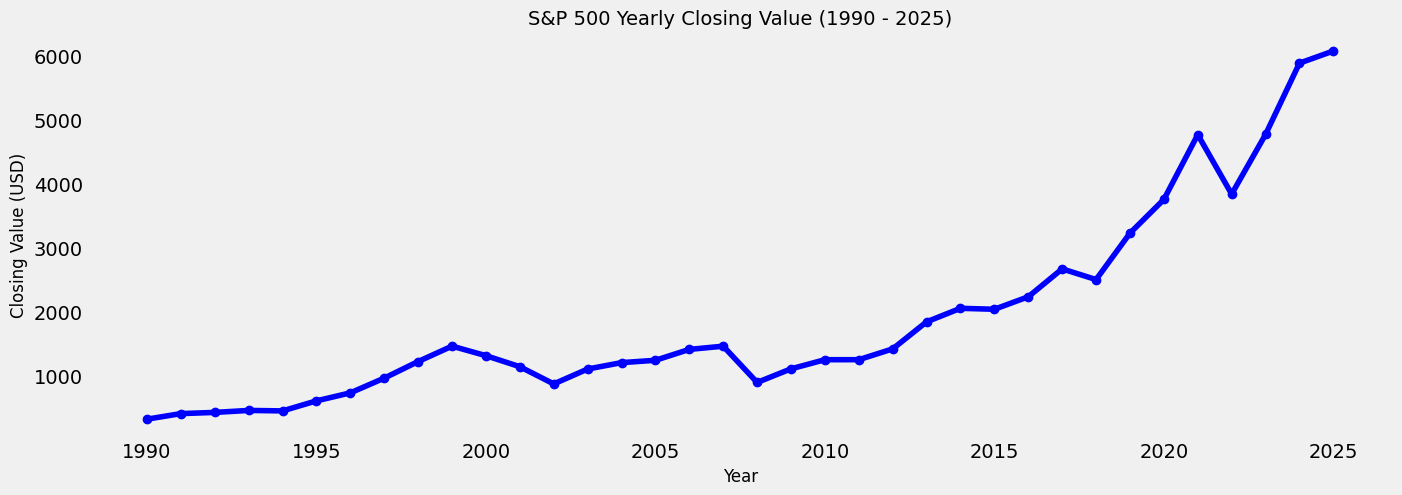

In [95]:
# First Graph: Yearly Closing Value
plt.figure(figsize=(15, 5))
plt.plot(yearly_growth_df['Year'], yearly_growth_df['Closing Value'], marker='o', color='blue')
plt.title('S&P 500 Yearly Closing Value (1990 - 2025)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Closing Value (USD)', fontsize=12)
plt.grid(False)
plt.show()

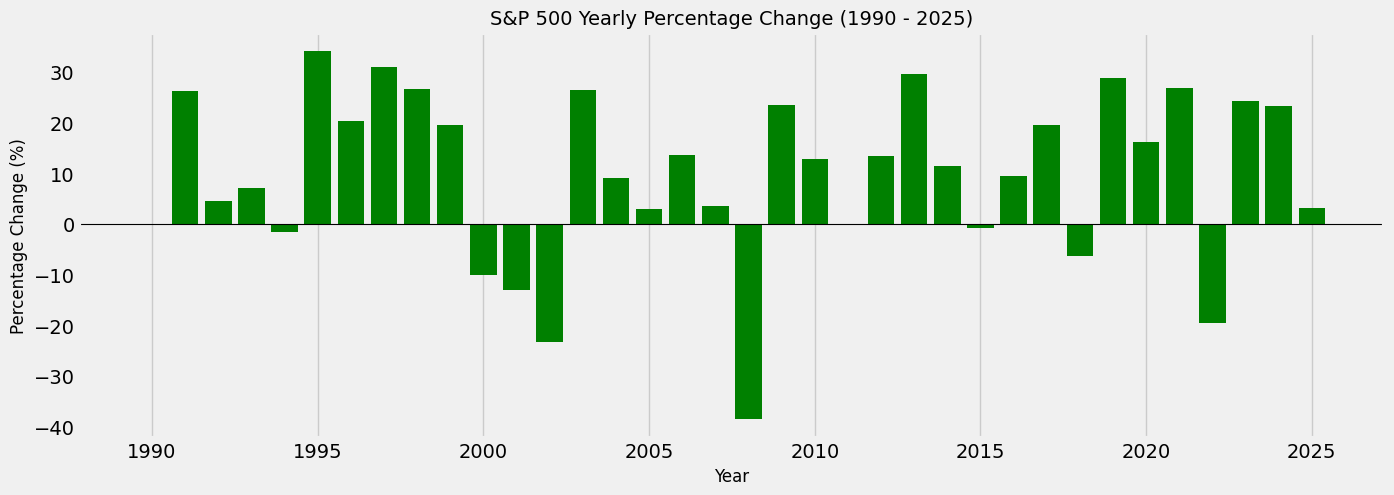

In [97]:
# Second Graph: Yearly Percentage Change
plt.figure(figsize=(15, 5))
plt.bar(yearly_growth_df['Year'], yearly_growth_df['% Change'], color='green')
plt.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at 0% for clarity
plt.title('S&P 500 Yearly Percentage Change (1990 - 2025)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.grid(axis='y')
plt.show()

## For XGboost

In [100]:
close_dataframe = csv_dataframe[["Close"]] #drop all columns only focus on close
future_dataframe = csv_dataframe[["Close", "Vix", "Volume"]]

In [102]:
future_dataframe

Price,Close,Vix,Volume
Date,,,
1990-01-02,359.69,17.24,162070000
1990-01-03,358.76,18.19,192330000
1990-01-04,355.67,19.22,177000000
1990-01-05,352.20,20.11,158530000
1990-01-08,353.79,20.26,140110000
...,...,...,...
2025-01-24,6101.24,14.85,4214250000
2025-01-27,6012.28,17.90,5198750000
2025-01-28,6067.70,16.41,4473640000


In [104]:
close_dataframe

Price,Close
Date,
1990-01-02,359.69
1990-01-03,358.76
1990-01-04,355.67
1990-01-05,352.20
1990-01-08,353.79
...,...
2025-01-24,6101.24
2025-01-27,6012.28
2025-01-28,6067.70


In [106]:
future_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8836 entries, 1990-01-02 to 2025-01-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8836 non-null   float64
 1   Vix     8836 non-null   float64
 2   Volume  8836 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 276.1 KB


In [108]:
close_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8836 entries, 1990-01-02 to 2025-01-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8836 non-null   float64
dtypes: float64(1)
memory usage: 138.1 KB


In [110]:
close_dataframe.tail(5) # see the last datapoint

Price,Close
Date,
2025-01-24,6101.24
2025-01-27,6012.28
2025-01-28,6067.70
2025-01-29,6039.31
2025-01-30,6071.17


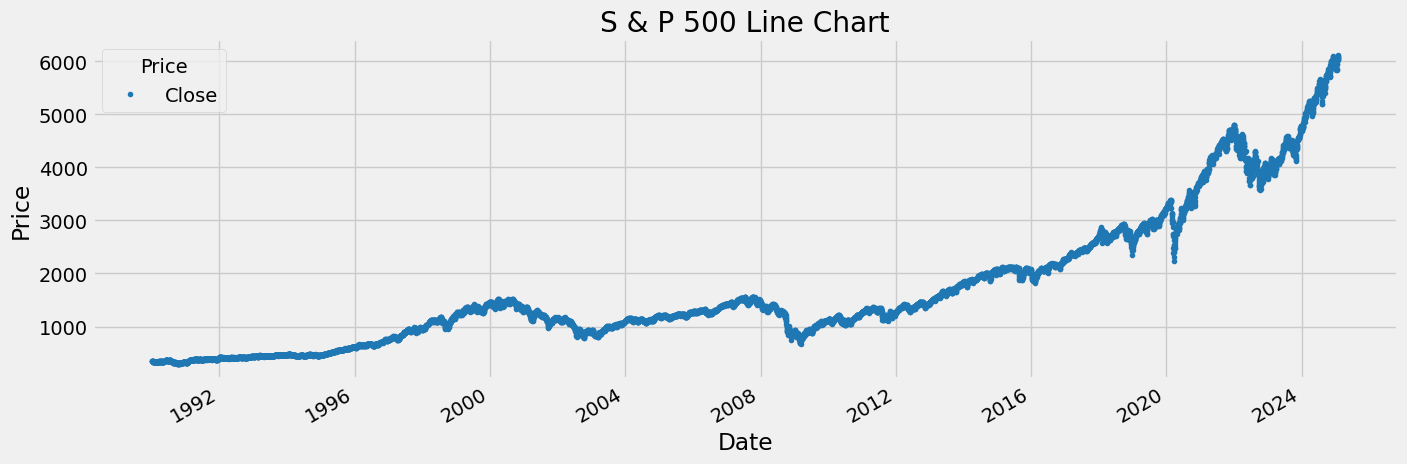

In [112]:
close_dataframe.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='S & P 500 Line Chart')

plt.xlabel('Date')  
plt.ylabel('Price') 

plt.show()

## S&P 500 from Jan 1 1990 to Jan 31 2025

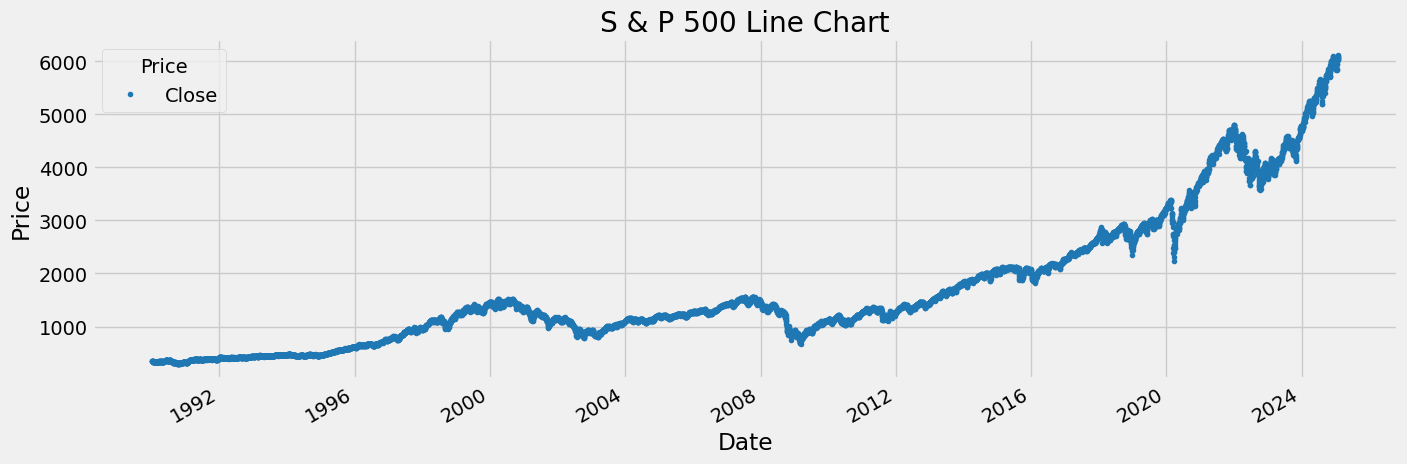

In [115]:
close_dataframe.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='S & P 500 Line Chart')

plt.xlabel('Date')  
plt.ylabel('Price') 

plt.show()

## Overview of data split between training and test date

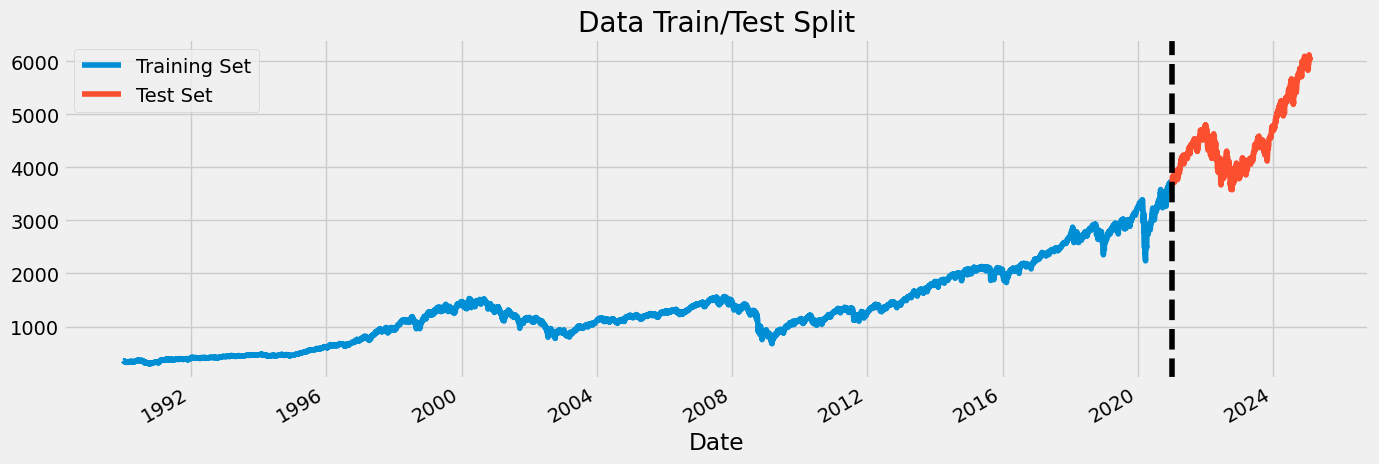

In [119]:
plot_train = close_dataframe.loc[close_dataframe.index < '01-01-2021'] #training data
plot_test = close_dataframe.loc[close_dataframe.index >= '01-01-2021'] #test set 

# Plot size
fig, ax = plt.subplots(figsize=(15, 5))

#Plot data
plot_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')

#Creating a divider
plot_test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--') #line black
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [122]:
train = future_dataframe.loc[future_dataframe.index < '01-01-2021'] #training data
test = future_dataframe.loc[future_dataframe.index >= '01-01-2021'] #test set 

start_date = pd.to_datetime('1990-01-01')
end_date = pd.to_datetime('2025-01-30')

# Filter the DataFrame based on the date range
df_1990 = future_dataframe[(future_dataframe.index >= start_date) & (future_dataframe.index <= end_date)] #dataset named as df_1990

# Show the filtered DataFrame
df_1990

Price,Close,Vix,Volume
Date,,,
1990-01-02,359.69,17.24,162070000
1990-01-03,358.76,18.19,192330000
1990-01-04,355.67,19.22,177000000
1990-01-05,352.20,20.11,158530000
1990-01-08,353.79,20.26,140110000
...,...,...,...
2025-01-24,6101.24,14.85,4214250000
2025-01-27,6012.28,17.90,5198750000
2025-01-28,6067.70,16.41,4473640000


## Feature Creation|

In [125]:
import pandas as pd

def create_features(df):
    df = df.copy()
    
    # Lag features for Close
    df['Close_Lag1'] = df['Close'].shift(1) 
    df['Close_Lag5'] = df['Close'].shift(5)
    
    # Lag features for VIX
    df['Vix_Lag1'] = df['Vix'].shift(1)
    df['Vix_Lag5'] = df['Vix'].shift(5)

    # Volume Features
    df['Volume_MA20'] = df['Volume'].rolling(window=20, min_periods=1).mean()
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_Volatility20'] = df['Volume'].rolling(window=20, min_periods=1).std()
    
    # Moving Averages for Close
    df['Close_MA7'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['Close_MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['Close_MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['Close_MA100'] = df['Close'].rolling(window=100, min_periods=1).mean()
    df['Close_MA200'] = df['Close'].rolling(window=200, min_periods=1).mean()
    
    # Volatility for Close
    df['Close_Volatility30'] = df['Close'].rolling(window=30, min_periods=1).std()
    
    # Moving Averages for VIX
    df['Vix_MA7'] = df['Vix'].rolling(window=7, min_periods=1).mean()
    df['Vix_Volatility30'] = df['Vix'].rolling(window=30, min_periods=1).std()
    
    # Time-based features
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    
    return df


In [127]:
df = create_features(df_1990)

In [129]:
df

Price,Close,Vix,Volume,Close_Lag1,Close_Lag5,Vix_Lag1,Vix_Lag5,Volume_MA20,Volume_Change,Volume_Volatility20,...,Close_Volatility30,Vix_MA7,Vix_Volatility30,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,359.69,17.24,162070000,NaN,NaN,NaN,NaN,162070000.00,NaN,NaN,...,NaN,17.24,NaN,1,1,1,1990,2,2,1
1990-01-03,358.76,18.19,192330000,359.69,NaN,17.24,NaN,177200000.00,0.19,21397051.20,...,0.66,17.72,0.67,2,1,1,1990,3,3,1
1990-01-04,355.67,19.22,177000000,358.76,NaN,18.19,NaN,177133333.33,-0.08,15130440.62,...,2.10,18.22,0.99,3,1,1,1990,4,4,1
1990-01-05,352.20,20.11,158530000,355.67,NaN,19.22,NaN,172482500.00,-0.10,15464189.55,...,3.39,18.69,1.24,4,1,1,1990,5,5,1
1990-01-08,353.79,20.26,140110000,352.20,NaN,20.11,NaN,166008000.00,-0.12,19721856.40,...,3.19,19.00,1.29,0,1,1,1990,8,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-24,6101.24,14.85,4214250000,6118.71,5937.34,15.02,16.60,3987837500.00,-0.05,785379004.83,...,87.85,15.53,2.99,4,1,1,2025,24,24,4
2025-01-27,6012.28,17.90,5198750000,6101.24,5996.66,14.85,15.97,4159889000.00,0.23,633305201.60,...,87.39,15.79,2.96,0,1,1,2025,27,27,5
2025-01-28,6067.70,16.41,4473640000,6012.28,6049.24,17.90,15.06,4238344500.00,-0.14,562879918.52,...,86.71,15.76,2.89,1,1,1,2025,28,28,5


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8836 entries, 1990-01-02 to 2025-01-30
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                8836 non-null   float64
 1   Vix                  8836 non-null   float64
 2   Volume               8836 non-null   int64  
 3   Close_Lag1           8835 non-null   float64
 4   Close_Lag5           8831 non-null   float64
 5   Vix_Lag1             8835 non-null   float64
 6   Vix_Lag5             8831 non-null   float64
 7   Volume_MA20          8836 non-null   float64
 8   Volume_Change        8835 non-null   float64
 9   Volume_Volatility20  8835 non-null   float64
 10  Close_MA7            8836 non-null   float64
 11  Close_MA20           8836 non-null   float64
 12  Close_MA50           8836 non-null   float64
 13  Close_MA100          8836 non-null   float64
 14  Close_MA200          8836 non-null   float64
 15  Close_Volatility30  

In [133]:
# Apply the feature creation to both train and test sets
train = create_features(train)
test = create_features(test)

FEATURES = [
    'Close_Lag1', 'Close_Lag5', 
    'Vix_Lag1', 'Vix_Lag5',
    'Close_MA7', 'Close_MA20', 'Close_MA50', 'Close_MA100', 'Close_MA200', 'Close_Volatility30',
    'Vix_MA7', 'Vix_Volatility30', 'Vix',
    'dayofweek', 'quarter', 'month', 'year',
    'Volume_MA20', 'Volume_Change', 'Volume_Volatility20',
    'dayofyear', 'dayofmonth', 'weekofyear'
]
TARGET = 'Close'

# training data set
X_train = train[FEATURES]
y_train = train[TARGET]

# testing data set
X_test = test[FEATURES]
y_test = test[TARGET]

In [135]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000, #1000 trees
                       early_stopping_rounds=50,
                       objective='reg:squarederror',  
                       max_depth=6,
                       learning_rate=0.01,
    reg_alpha=0.1,  # Reduced regularization
    reg_lambda=1  # Reduced regularization
)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:1510.39313	validation_1-rmse:4559.61731
[100]	validation_0-rmse:555.63077	validation_1-rmse:2437.49536
[200]	validation_0-rmse:205.01323	validation_1-rmse:1615.82534
[300]	validation_0-rmse:76.76534	validation_1-rmse:1323.22428
[400]	validation_0-rmse:30.76428	validation_1-rmse:1219.66803
[500]	validation_0-rmse:15.44307	validation_1-rmse:1181.05738
[600]	validation_0-rmse:10.86381	validation_1-rmse:1167.28976
[700]	validation_0-rmse:9.22811	validation_1-rmse:1160.71361
[800]	validation_0-rmse:8.33912	validation_1-rmse:1158.09522
[900]	validation_0-rmse:7.73727	validation_1-rmse:1156.95626
[999]	validation_0-rmse:7.25370	validation_1-rmse:1156.49535


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [137]:
reg.feature_importances_

array([3.7038270e-01, 4.2242449e-02, 3.7874852e-05, 2.9379436e-05,
       3.2059747e-01, 1.8720041e-01, 5.6395233e-02, 1.8243374e-02,
       4.9573701e-04, 1.5392006e-05, 2.4828329e-05, 1.3858531e-05,
       4.5711768e-05, 9.6731901e-06, 3.3284930e-05, 8.2970757e-05,
       3.9099888e-03, 4.7538175e-05, 2.1794634e-05, 2.0110445e-05,
       3.9654940e-05, 2.4192999e-05, 8.6374195e-05], dtype=float32)

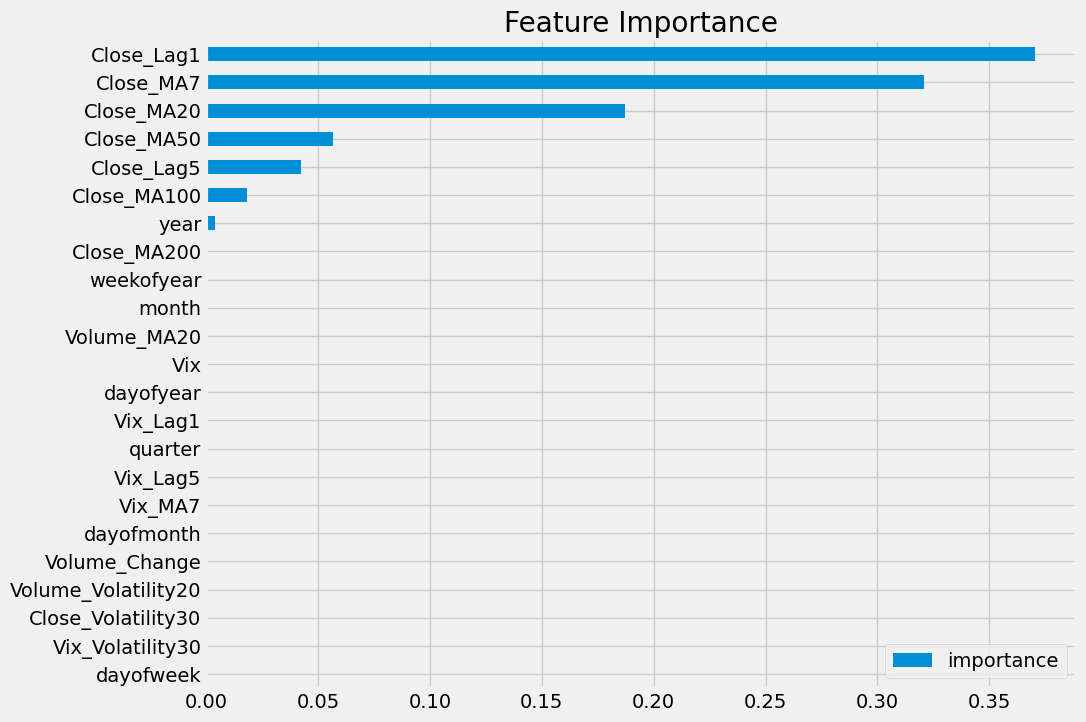

In [139]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

# Sort values by importance in descending order
fi.sort_values('importance', ascending=True).plot(kind='barh', title='Feature Importance', figsize=(10, 8))

plt.legend(loc='lower right')

# Show plot
plt.show()


## forecast using train model

In [142]:
test['prediction'] = reg.predict(X_test)

In [144]:
# Merge the dataframes with suffixes to avoid duplicate column names
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True, suffixes=('', '_test'))

# Show the merged dataframe
df


Price,Close,Vix,Volume,Close_Lag1,Close_Lag5,Vix_Lag1,Vix_Lag5,Volume_MA20,Volume_Change,Volume_Volatility20,...,Vix_MA7,Vix_Volatility30,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,359.69,17.24,162070000,NaN,NaN,NaN,NaN,162070000.00,NaN,NaN,...,17.24,NaN,1,1,1,1990,2,2,1,NaN
1990-01-03,358.76,18.19,192330000,359.69,NaN,17.24,NaN,177200000.00,0.19,21397051.20,...,17.72,0.67,2,1,1,1990,3,3,1,NaN
1990-01-04,355.67,19.22,177000000,358.76,NaN,18.19,NaN,177133333.33,-0.08,15130440.62,...,18.22,0.99,3,1,1,1990,4,4,1,NaN
1990-01-05,352.20,20.11,158530000,355.67,NaN,19.22,NaN,172482500.00,-0.10,15464189.55,...,18.69,1.24,4,1,1,1990,5,5,1,NaN
1990-01-08,353.79,20.26,140110000,352.20,NaN,20.11,NaN,166008000.00,-0.12,19721856.40,...,19.00,1.29,0,1,1,1990,8,8,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-24,6101.24,14.85,4214250000,6118.71,5937.34,15.02,16.60,3987837500.00,-0.05,785379004.83,...,15.53,2.99,4,1,1,2025,24,24,4,3576.00
2025-01-27,6012.28,17.90,5198750000,6101.24,5996.66,14.85,15.97,4159889000.00,0.23,633305201.60,...,15.79,2.96,0,1,1,2025,27,27,5,3538.96
2025-01-28,6067.70,16.41,4473640000,6012.28,6049.24,17.90,15.06,4238344500.00,-0.14,562879918.52,...,15.76,2.89,1,1,1,2025,28,28,5,3572.38


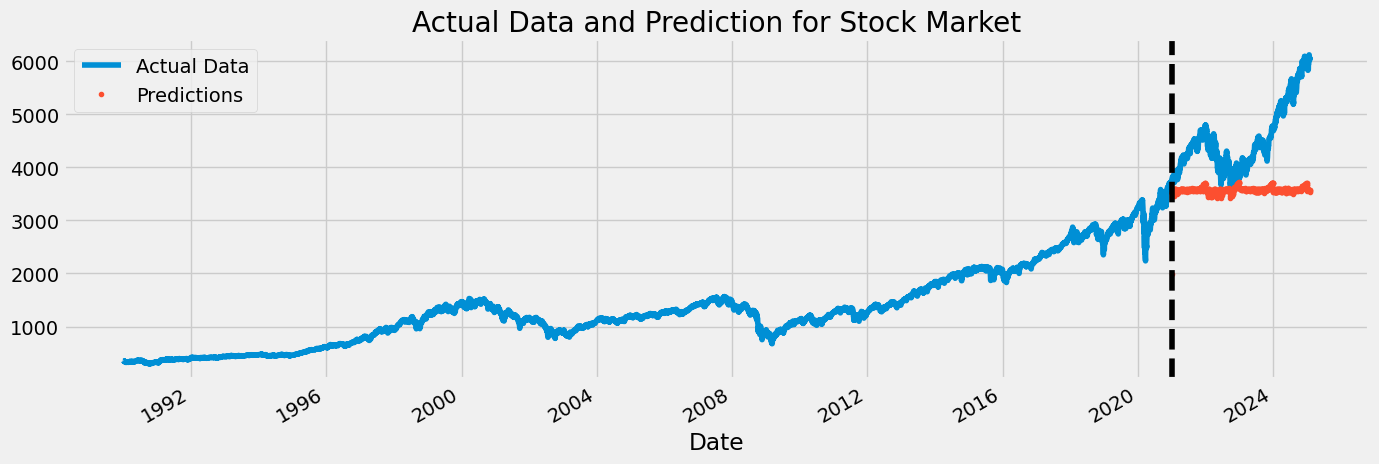

In [147]:
ax = df[['Close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.axvline('01-01-2021', color='black', ls='--') #line black
ax.set_title('Actual Data and Prediction for Stock Market')
plt.show()

In [150]:
# Root Mean Squared Error  measures the average difference between values predicted by a model and the actual values. 
score = np.sqrt(mean_squared_error(test['Close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.3f}')

RMSE Score on Test set: 1156.495


In [152]:
#calucating the error - making the numbers abs so that the difference can be seen properly
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['time'] = test.index.date

In [154]:
test.groupby(['time'])['error'].mean().sort_values(ascending=False).head(10)

time
2025-01-23   2543.95
2025-01-24   2525.24
2025-01-30   2513.10
2025-01-22   2510.77
2025-01-28   2495.32
2025-01-21   2477.88
2025-01-29   2474.54
2025-01-27   2473.32
2025-01-17   2415.44
2024-12-06   2413.58
Name: error, dtype: float64

In [156]:
test.groupby(['time'])['error'].mean().sort_values(ascending=True).head(10)
#best predicted dates

time
2022-12-28    63.16
2022-10-12    76.30
2022-10-14    88.94
2022-12-19   110.16
2022-12-20   116.03
2022-10-10   116.26
2022-11-09   118.42
2022-12-30   118.86
2022-12-22   118.91
2022-11-03   119.00
Name: error, dtype: float64

## Part 3: analysis - looking at S&P 500  companies

In [159]:
csv_dataframe_2

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,3846819807232,134660997120.00,0.06,Cupertino,CA,United States,164000.00,"Apple Inc. designs, manufactures, and markets ...",0.07
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,3298803056640,61184000000.00,1.22,Santa Clara,CA,United States,29600.00,NVIDIA Corporation provides graphics and compu...,0.06
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,3246068596736,136551997440.00,0.16,Redmond,WA,United States,228000.00,Microsoft Corporation develops and supports so...,0.06
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,2365033807872,111583002624.00,0.11,Seattle,WA,United States,1551000.00,"Amazon.com, Inc. engages in the retail sale of...",0.04
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,2351625142272,123469996032.00,0.15,Mountain View,CA,United States,181269.00,Alphabet Inc. offers various products and plat...,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,NMS,CZR,"Caesars Entertainment, Inc.","Caesars Entertainment, Inc.",Consumer Cyclical,Resorts & Casinos,32.82,6973593600,3668000000.00,-0.04,Reno,NV,United States,51000.00,"Caesars Entertainment, Inc. operates as a gami...",0.00
498,NYQ,BWA,BorgWarner Inc.,BorgWarner Inc.,Consumer Cyclical,Auto Parts,31.88,6972155904,1882000000.00,-0.05,Auburn Hills,MI,United States,39900.00,"BorgWarner Inc., together with its subsidiarie...",0.00
499,NMS,QRVO,"Qorvo, Inc.","Qorvo, Inc.",Technology,Semiconductors,70.85,6697217024,673129984.00,-0.05,Greensboro,NC,United States,8700.00,"Qorvo, Inc. engages in development and commerc...",0.00
500,NYQ,FMC,FMC Corporation,FMC Corporation,Basic Materials,Agricultural Inputs,50.15,6260525568,703299968.00,0.09,Philadelphia,PA,United States,5800.00,"FMC Corporation, an agricultural sciences comp...",0.00


In [161]:
csv_dataframe_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exchange             502 non-null    object 
 1   Symbol               502 non-null    object 
 2   Shortname            502 non-null    object 
 3   Longname             502 non-null    object 
 4   Sector               502 non-null    object 
 5   Industry             502 non-null    object 
 6   Currentprice         502 non-null    float64
 7   Marketcap            502 non-null    int64  
 8   Ebitda               473 non-null    float64
 9   Revenuegrowth        499 non-null    float64
 10  City                 502 non-null    object 
 11  State                482 non-null    object 
 12  Country              502 non-null    object 
 13  Fulltimeemployees    493 non-null    float64
 14  Longbusinesssummary  502 non-null    object 
 15  Weight               502 non-null    flo

In [163]:
csv_dataframe_2.value_counts("Sector", ascending = False)

Sector
Technology                82
Industrials               70
Financial Services        67
Healthcare                62
Consumer Cyclical         55
Consumer Defensive        37
Utilities                 32
Real Estate               31
Basic Materials           22
Communication Services    22
Energy                    22
Name: count, dtype: int64

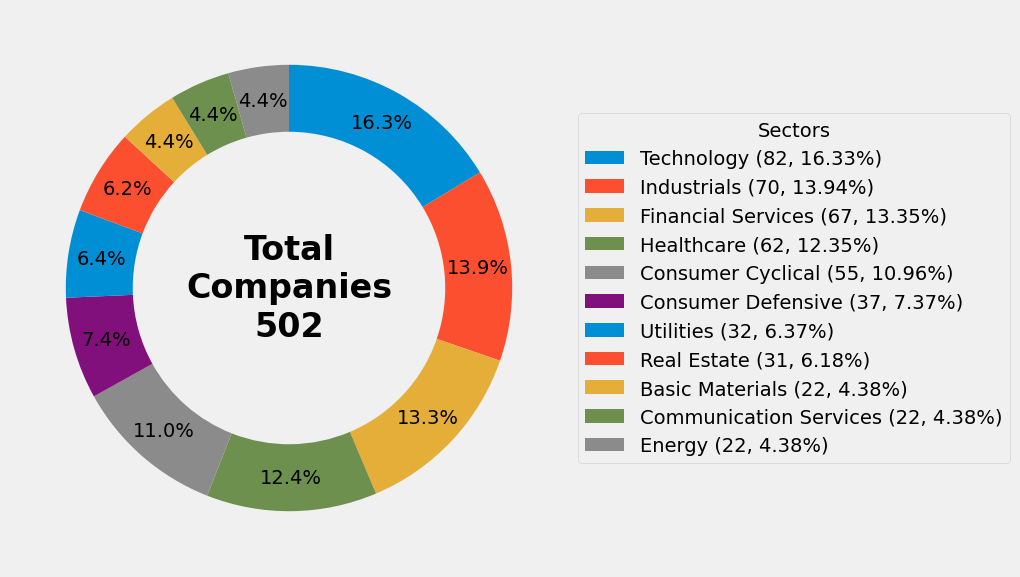

In [165]:
# Data for sectors
sectors = {
    'Technology': 82,
    'Industrials': 70,
    'Financial Services': 67,
    'Healthcare': 62,
    'Consumer Cyclical': 55,
    'Consumer Defensive': 37,
    'Utilities': 32,
    'Real Estate': 31,
    'Basic Materials': 22,
    'Communication Services': 22,
    'Energy': 22
}

# Calculate total and percentages
total = sum(sectors.values())
percentages = [(count/total)*100 for count in sectors.values()]

# Create the donut plot
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autotexts = ax.pie(
    percentages,
    labels=None,  # Remove labels from pie slices
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    autopct='%1.1f%%',
    pctdistance=0.85
)

# Add center text
plt.text(0, 0, f'Total\nCompanies\n{total}', 
         ha='center', va='center', 
         fontsize=24, fontweight='bold')

# Create legend with percentages and counts
legend_labels = [f'{label} ({count}, {percentage:.2f}%)' 
                 for label, count, percentage in zip(sectors.keys(), sectors.values(), percentages)]
plt.legend(wedges, legend_labels,
          title="Sectors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

In [167]:
marketcap = csv_dataframe_2.groupby("Sector")['Marketcap'].sum()
#https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/

In [169]:
marketcap_df = marketcap.to_frame(name="Market Cap")

In [171]:
marketcap_df
marketcap_df.reset_index(inplace=True)

In [173]:
marketcap_df

,Sector,Market Cap
0,Basic Materials,864553002496
1,Communication Services,7804046435328
2,Consumer Cyclical,6372352768000
3,Consumer Defensive,3253838582784
4,Energy,1598671836672
5,Financial Services,7108162940416
6,Healthcare,5190430794752
7,Industrials,3764601742336
8,Real Estate,1081488948224
9,Technology,17287013398528


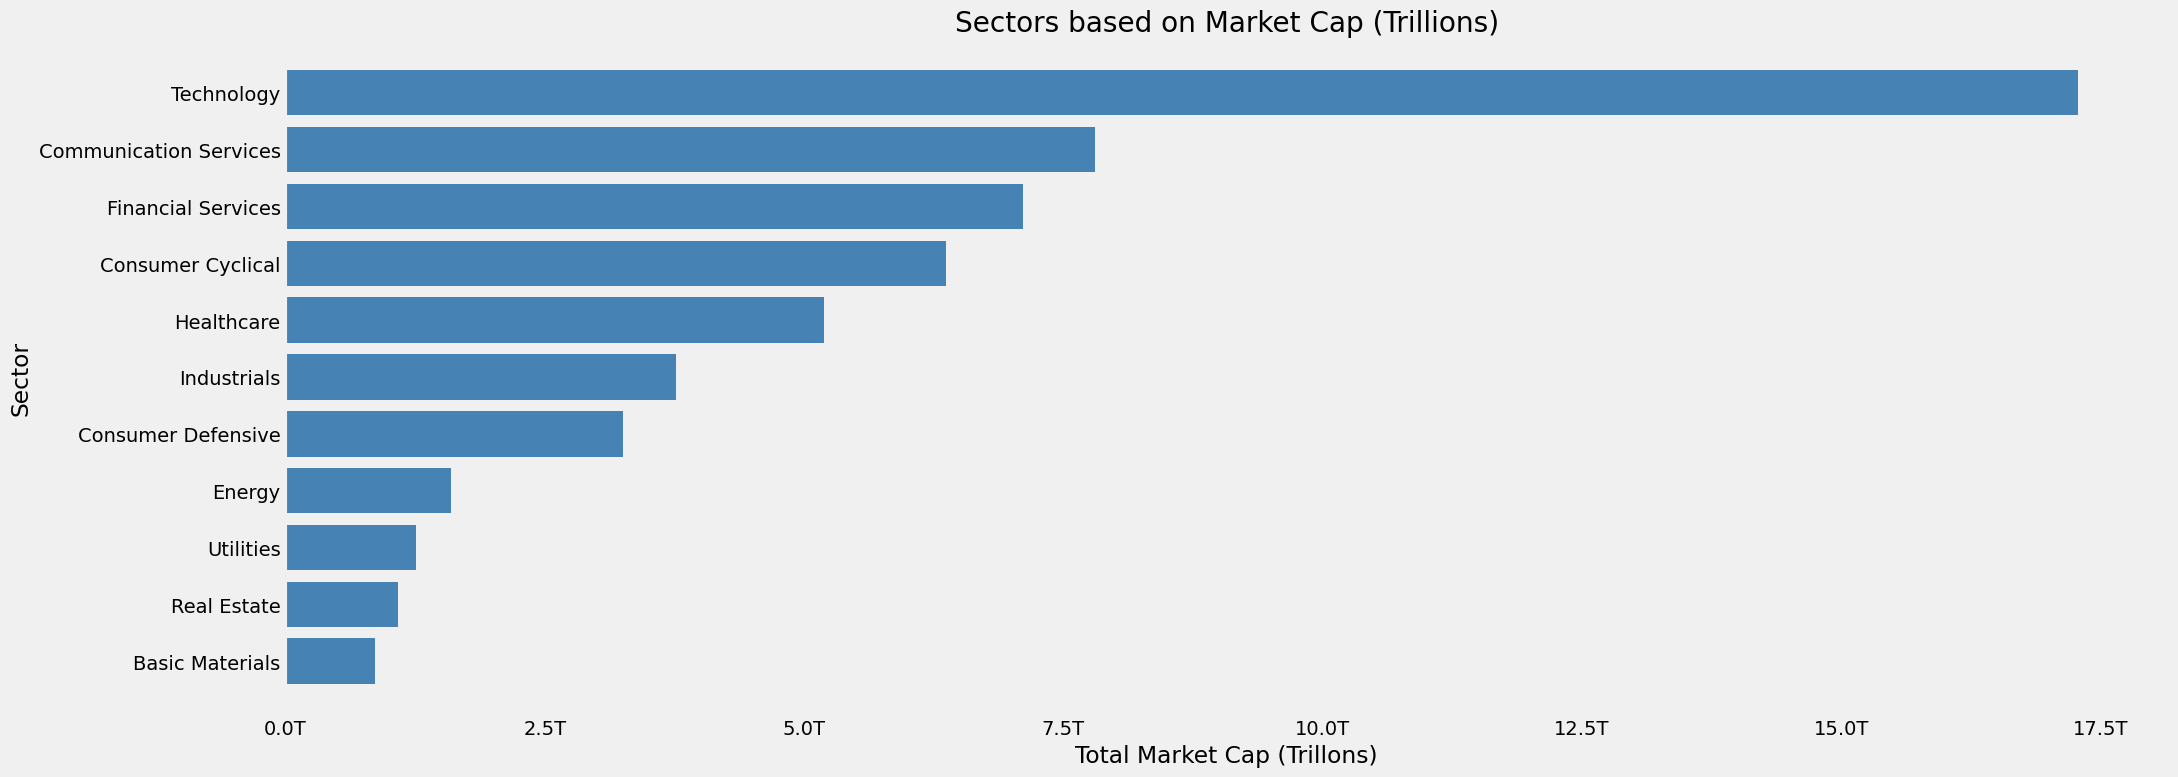

In [175]:
# Sort by Market Cap (descending order)
market_caps = marketcap_df.sort_values(by='Market Cap', ascending=True)

# Create plot
plt.figure(figsize=(22, 8))
plt.barh(market_caps['Sector'], market_caps['Market Cap'], color='steelblue')

# Format x-axis to prevent scientific notation
plt.gca().xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e12:.1f}T')  # Format as trillions
)

plt.xlabel('Total Market Cap (Trillons)')
plt.ylabel('Sector')
plt.title('Sectors based on Market Cap (Trillions)')
plt.grid(False)
plt.tight_layout()
plt.show()

In [177]:
## Part 2: analysis - looking at tech stocks which has the highest return

In [179]:
tickers = ["AAPL", "GOOG", "MSFT", "AMZN", "META", "NFLX"]
data = yf.download(tickers)
data.reset_index(inplace=True)
data = data.dropna()
data = data.sort_index()

[*********************100%***********************]  6 of 6 completed


In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3202 entries, 7930 to 11131
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        3202 non-null   datetime64[ns]
 1   (Close, AAPL)   3202 non-null   float64       
 2   (Close, AMZN)   3202 non-null   float64       
 3   (Close, GOOG)   3202 non-null   float64       
 4   (Close, META)   3202 non-null   float64       
 5   (Close, MSFT)   3202 non-null   float64       
 6   (Close, NFLX)   3202 non-null   float64       
 7   (High, AAPL)    3202 non-null   float64       
 8   (High, AMZN)    3202 non-null   float64       
 9   (High, GOOG)    3202 non-null   float64       
 10  (High, META)    3202 non-null   float64       
 11  (High, MSFT)    3202 non-null   float64       
 12  (High, NFLX)    3202 non-null   float64       
 13  (Low, AAPL)     3202 non-null   float64       
 14  (Low, AMZN)     3202 non-null   float64       
 15  (Low,

In [183]:
p1 = figure(x_axis_type="datetime", title="Adjusted Close Stock Prices")
p1.grid.grid_line_alpha = 0.3
p1.xaxis.axis_label = "Date"
p1.yaxis.axis_label = "Price"

for i, tick in enumerate(tickers):
    p1.line(data[('Date',)], data[('Close', tick)], color=Category10_6[i], legend_label=tick)
p1.legend.location = "top_left"

show(p1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_30620\2872541507.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p1.line(data[('Date',)], data[('Close', tick)], color=Category10_6[i], legend_label=tick)
